In [1]:
import pandas as pd
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [2]:
accidents = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_46860\901670543.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv("../PrometneNesreče.csv")


In [3]:
# Priprava podatkov
accidents['NastanekDatumCas'] = pd.to_datetime(accidents['NastanekDatumCas'], format='ISO8601', errors='coerce')
print(f"NastanekDatumCas column dtype: {accidents['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns]


# CosinorPy - pomlad

In [4]:
spring_mask = accidents['NastanekDatumCas'].dt.month.isin([3, 4, 5])

spring_accidents = accidents[spring_mask]
# print(f"NastanekDatumCas column dtype: {spring_accidents['NastanekDatumCas'].dtype}")

hours = spring_accidents['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()
accidents_per_hour = accidents_per_hour.sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsSpring",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

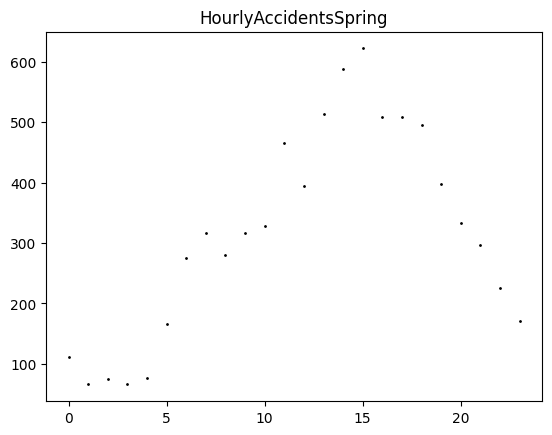

In [5]:
cosinor.plot_data(df_plot, names=["HourlyAccidentsSpring"])

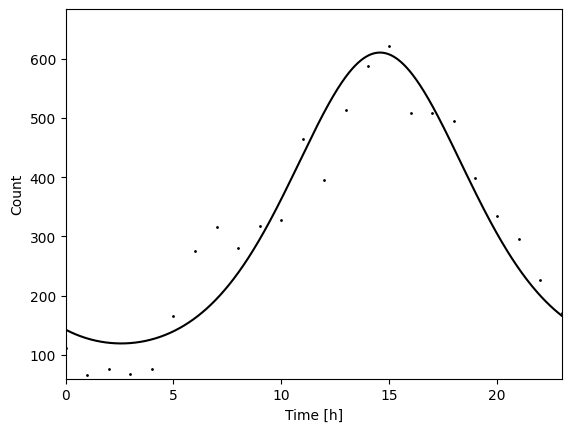

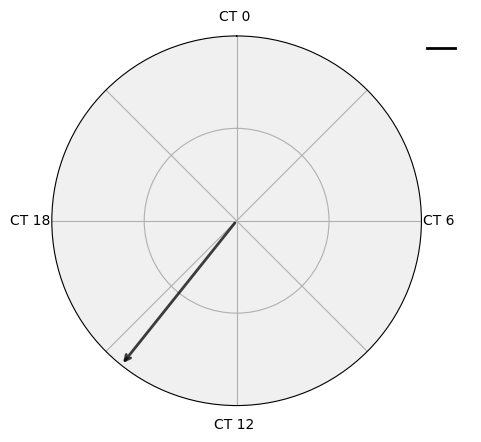

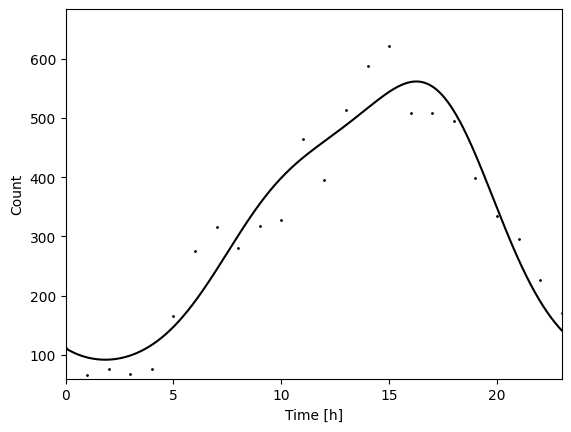

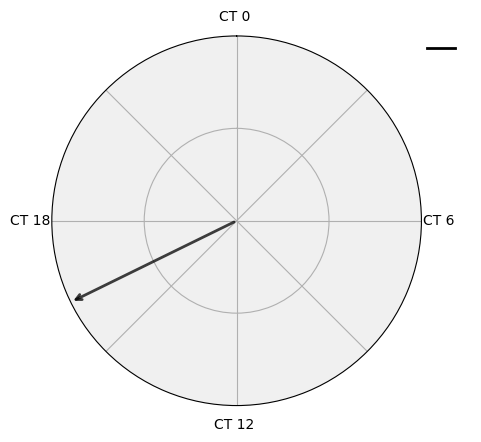

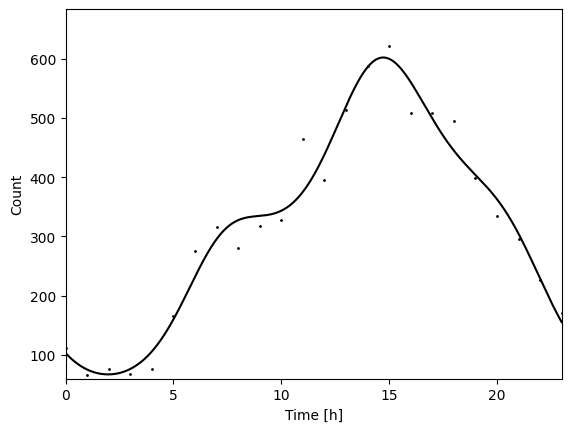

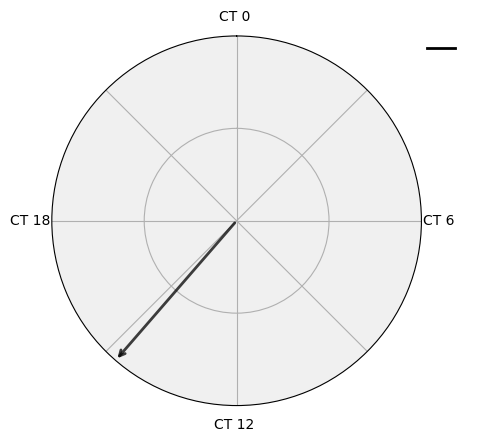

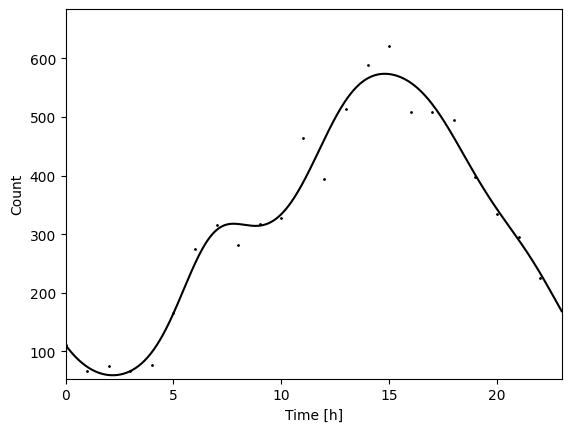

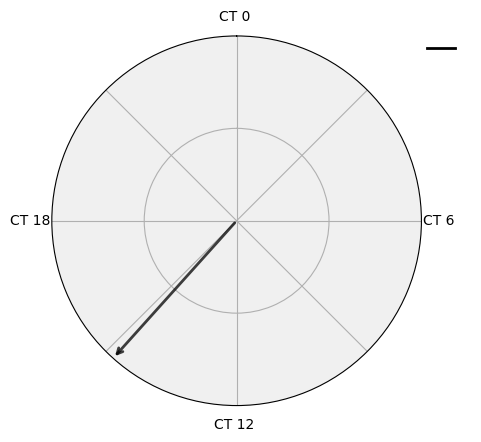

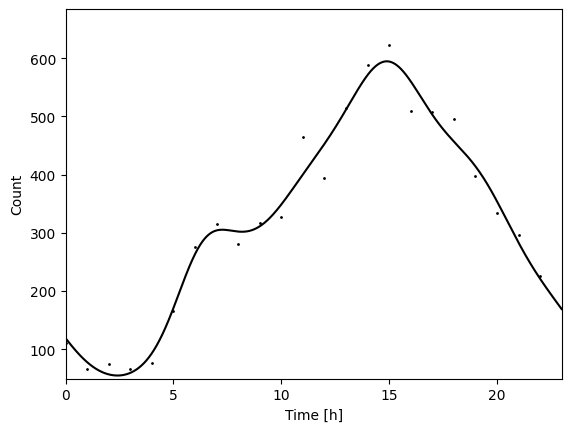

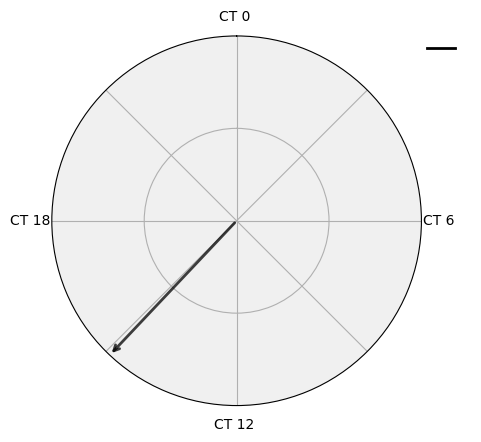

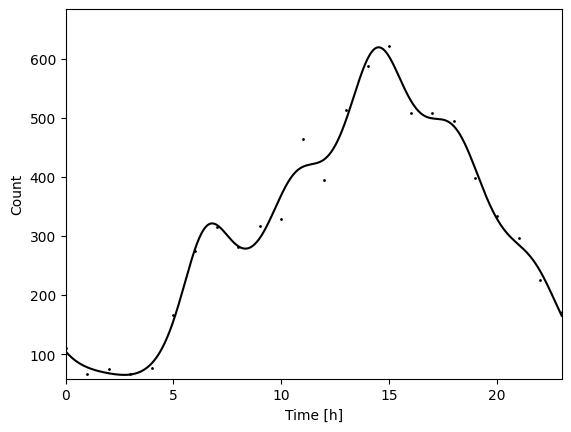

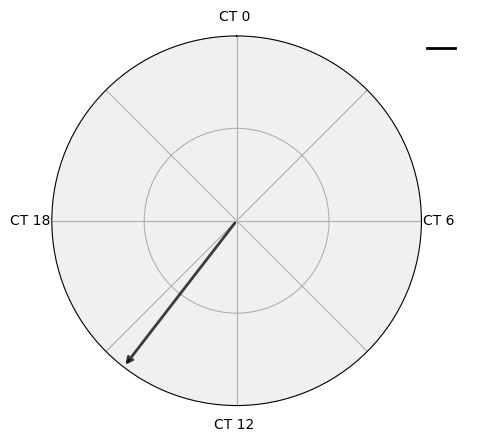

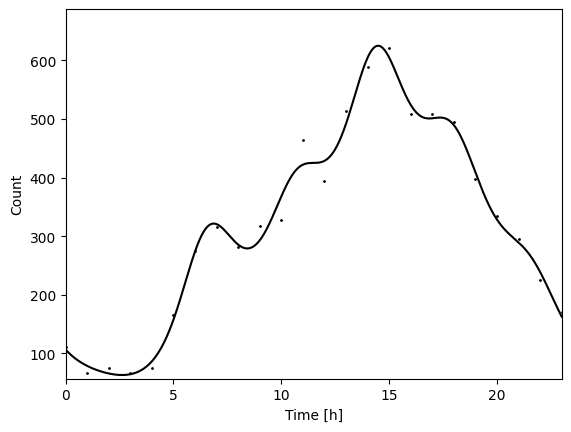

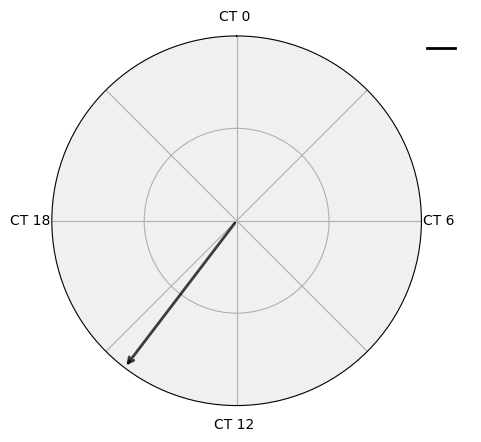

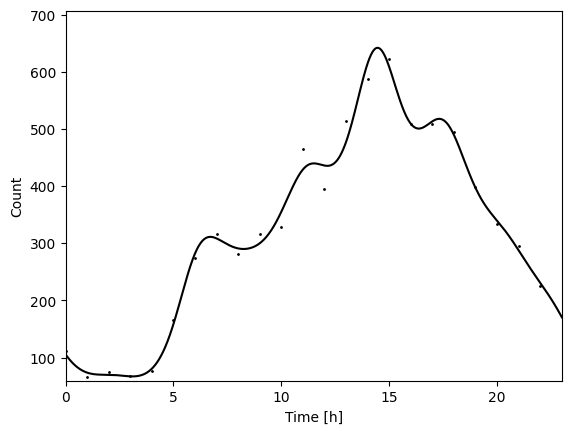

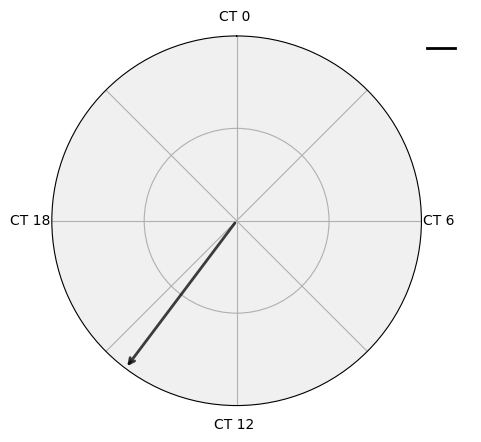

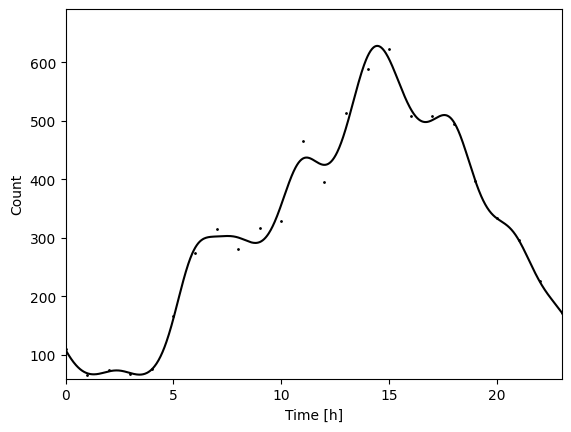

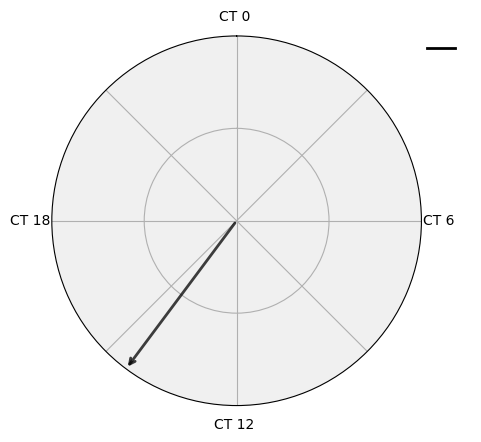

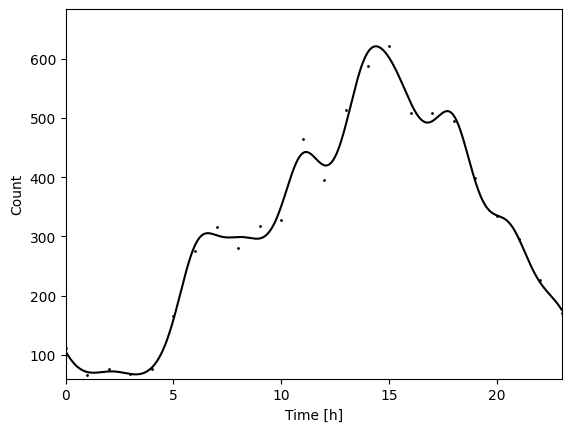

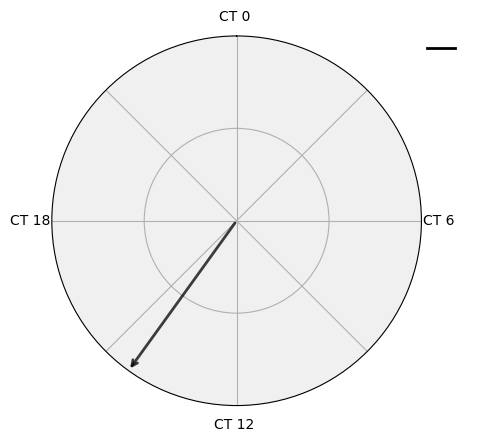

In [18]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))
    # print(results.__dict__.keys())
    # print(results.summary())
    # print("AIC in BIC", results.aic, results.bic)
    # help(results)


    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsSpring', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'AIC': results.aic,
        'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_plot)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidentsSpring', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model na podlagi likelihood-ratio testa
df_best_model = pd.DataFrame([{
        'test': 'HourlyAccidentsSpring',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        'AIC': results_simpler.aic,
        'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])


In [19]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,AIC,BIC
0,HourlyAccidentsSpring,24.0,1.0,1.768213e-12,1.768213e-12,73216.509012,-131.820025,0.170323,245.870047,2.467654,364.907948,[14.574257425742575],[610.7779955638317],[2.5730573057305732],[119.03791732100463],271.640051,276.352266
1,HourlyAccidentsSpring,24.0,2.0,4.400797e-14,4.889775e-14,50873.122634,-124.562256,0.216003,235.163634,2.026530,326.721969,[16.25922592259226],[561.8856026092157],[1.8385838583858387],[91.55834556450098],261.124511,268.192834
2,HourlyAccidentsSpring,24.0,3.0,2.287278e-17,3.267540e-17,23080.113524,-113.587152,0.285081,267.856814,2.427437,334.564760,[14.727872787278729],[602.4215740055008],[1.9681968196819684],[66.70795801803577],243.174304,252.598735
3,HourlyAccidentsSpring,24.0,4.0,2.204461e-17,3.267540e-17,20184.654253,-110.627154,0.303711,257.250436,2.409843,316.579986,"[7.786378637863787, 14.795079507950796]","[317.92585165432905, 573.8303860210331]","[2.1842184218421843, 8.7992799279928]","[59.329557439771094, 314.2268166292528]",241.254307,253.034845
4,HourlyAccidentsSpring,24.0,5.0,3.835858e-17,4.794822e-17,15665.120167,-108.500182,0.317098,269.813439,2.384707,324.755204,[14.891089108910892],[594.5686434453968],"[2.4002400240024, 8.175217521752176]","[54.94179350947451, 301.8582273942309]",241.000363,255.137009
5,HourlyAccidentsSpring,24.0,6.0,3.079155e-19,3.079155e-18,8081.816933,-100.632450,0.366618,277.357780,2.483992,342.196169,[14.511851185118513],[619.5536655021647],"[2.7170717071707173, 8.333633363336334]","[64.838393021315, 278.63565324292495]",229.264900,245.757654
6,HourlyAccidentsSpring,24.0,7.0,2.233313e-18,5.039962e-18,7433.193503,-100.287591,0.368788,280.931738,2.490275,344.171542,"[14.487848784878489, 17.363336333633363]","[625.1032517645974, 502.5858327933866]","[2.6114611461146118, 8.42004200420042]","[63.239827065300275, 279.2276592824268]",232.575182,251.424044
7,HourlyAccidentsSpring,24.0,8.0,1.008588e-18,3.361961e-18,6824.036402,-96.970686,0.389665,287.658202,2.496559,354.618406,"[11.511551155115512, 14.463846384638465, 17.32...","[439.93421114693916, 642.2766081551728, 517.92...","[3.0963096309630966, 8.252025202520253]","[66.96023046303334, 290.0535213577561]",229.941373,251.146342
8,HourlyAccidentsSpring,24.0,9.0,7.460056e-19,3.361961e-18,5486.992667,-94.269154,0.406668,280.812391,2.500329,347.179617,"[11.170717071707172, 14.44944494449445, 17.560...","[437.2405066475433, 627.9920078433892, 509.864...","[1.300930093009301, 3.422742274227423, 8.79447...","[66.89160446308985, 66.36722612026836, 291.347...",228.538308,252.099384
9,HourlyAccidentsSpring,24.0,10.0,2.519981e-18,5.039962e-18,5014.943475,-93.376445,0.412287,277.321455,2.516667,344.056660,"[11.151515151515152, 14.387038703870388, 17.69...","[442.68666801606946, 621.3779048981454, 511.80...","[1.2961296129612963, 3.2451245124512456, 7.570...","[69.50761608041114, 66.73527566929253, 298.161...",230.752890,256.670074


### Katero je najboljše število komponent

In [20]:
# df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,RSS,log-likelihood,prsquared,AIC,BIC,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsSpring,24,3,2.287278e-17,23080.113524,-113.587152,0.285081,243.174304,252.598735,267.856814,2.427437,334.56476,[14.727872787278729],[602.4215740055008],[1.9681968196819684],[66.70795801803577]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


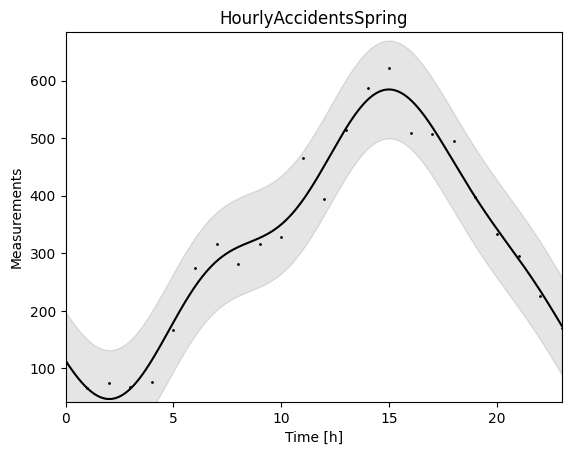

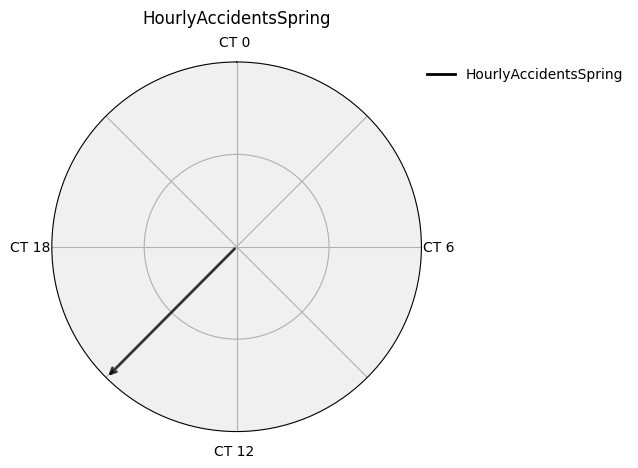

In [21]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [10]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsSpring",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [11]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

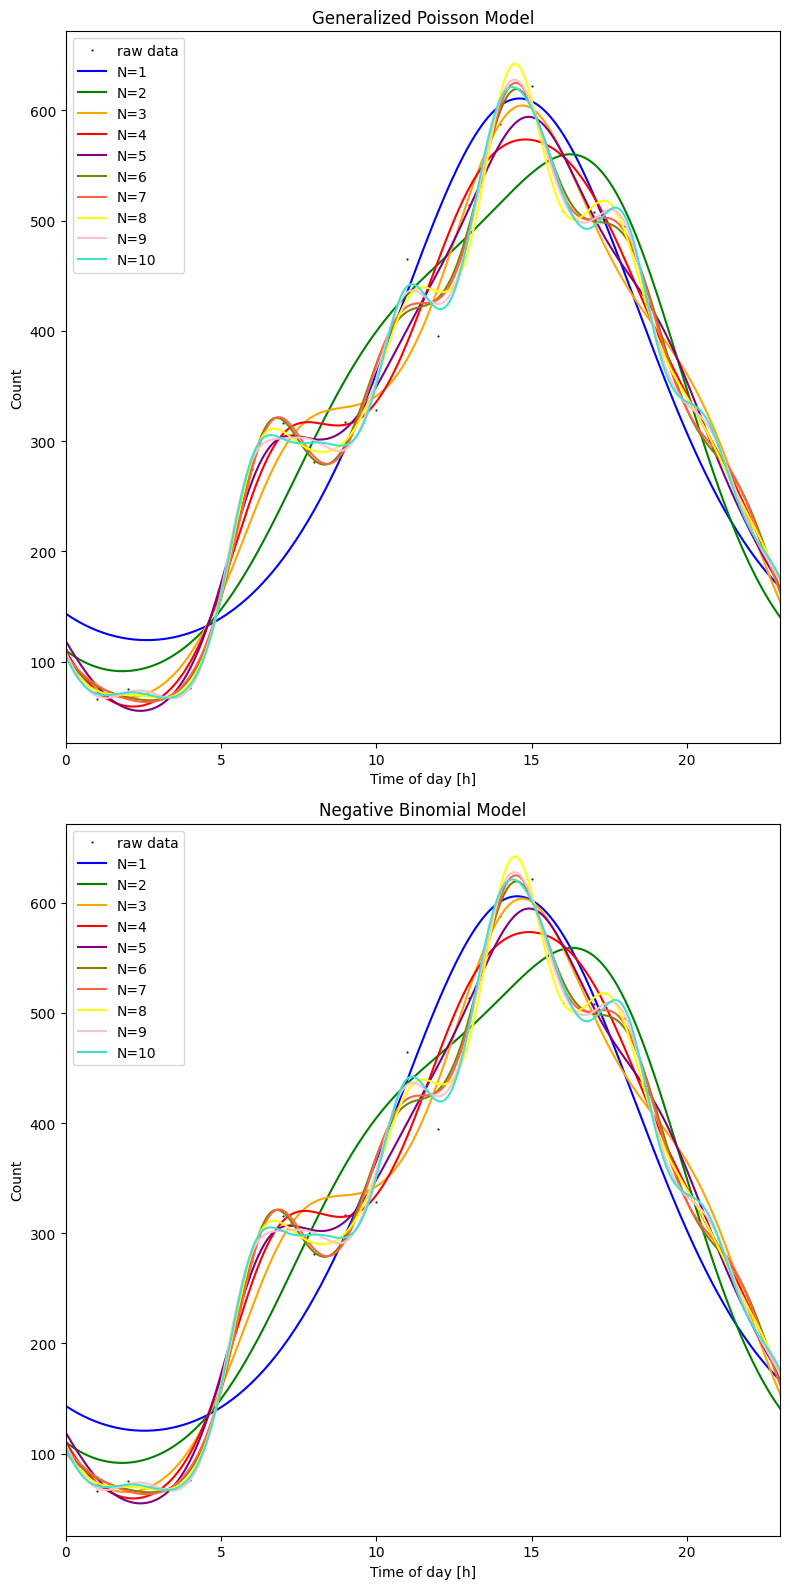

In [12]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [13]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,245.68,365.11,[14.61],[610.78],1.784658e-12,72694.637814,271.658566,276.370781,-131.829283,"[-4.7377089671750525, -5.672110297580346, -4.9...",316.950836,"[143.4440375582008, 128.27256680646795, 120.67...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[143.4440375582008, 141.5512457044075, 139.745..."
1,gen_poisson,2,234.43,325.69,[16.22],[560.12],4.418793e-14,50799.236546,261.132911,268.201234,-124.566455,"[-4.284689967770291, -4.5747249026821635, -4.1...",316.016512,"[110.30484325405567, 94.9650627249715, 91.4122...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[110.30484325405567, 108.16441561196422, 106.1..."
2,gen_poisson,3,268.56,335.90,[14.71],[604.45],3.285423e-17,23033.879527,243.931397,253.355828,-113.965699,"[-3.86418894710134, -3.659701288699324, -3.721...",316.025678,"[102.8081071497615, 75.24686426353972, 67.3409...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[102.8081071497615, 99.01559185790474, 95.4675..."
3,gen_poisson,4,257.21,316.37,[14.81],[573.58],1.268614e-16,20197.909751,244.985860,256.766398,-112.492930,"[-3.4378132609758723, -3.4334633484042456, -4....",316.625000,"[109.93393438377011, 73.27219202394517, 59.457...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[109.93393438377011, 105.17650895838501, 100.6..."
4,gen_poisson,5,269.46,324.71,[14.91],[594.17],5.174528e-17,15765.023041,241.649726,255.786372,-108.824863,"[-3.6460788157201165, -3.847322905052124, -4.9...",316.625000,"[118.76400925628307, 77.99864255674804, 57.186...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[118.76400925628307, 114.05898139857472, 109.4..."
5,gen_poisson,6,277.30,342.13,[14.51],[619.43],3.864960e-19,8081.287145,229.761433,246.254186,-100.880716,"[-3.4049297728349615, -4.050860854180328, -3.4...",316.623165,"[104.53821734717928, 77.65071456656872, 67.510...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[104.53821734717928, 100.51847821552643, 96.84..."
6,gen_poisson,7,280.91,344.15,"[14.51, 17.32]","[625.05, 502.57]",2.616518e-18,7433.932038,232.927355,251.776217,-100.463678,"[-3.2796712556266954, -4.259624451053199, -3.7...",316.625000,"[106.51619723972222, 78.74677018921986, 65.830...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[106.51619723972222, 102.66723059691293, 99.10..."
7,gen_poisson,8,287.46,354.54,"[14.41, 17.32]","[642.0, 518.06]",1.055589e-18,6826.320526,230.043857,251.248826,-97.021928,"[-3.343061365477567, -3.4091942520215213, -3.1...",316.625000,"[105.36170501944972, 73.51839831406873, 69.841...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[105.36170501944972, 100.25009956420148, 95.57..."
8,gen_poisson,9,280.67,347.21,"[14.41, 17.52]","[627.88, 509.94]",1.204574e-18,5486.642676,229.630033,253.191110,-94.815016,"[-3.192991075672154, -2.983195468589315, -3.03...",316.625000,"[108.63254507428088, 68.84659710503034, 72.046...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[108.63254507428088, 102.34516556127825, 96.46..."
9,gen_poisson,10,277.15,344.10,"[14.41, 17.72]","[621.25, 511.89]",5.076118e-18,5015.121502,232.373725,258.290909,-94.186862,"[-3.330760673165443, -3.118507733114072, -3.04...",316.625000,"[105.55137485283808, 70.79666155797075, 71.843...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[105.55137485283808, 99.48406610075072, 93.982..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [14]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 6


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [15]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 6
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

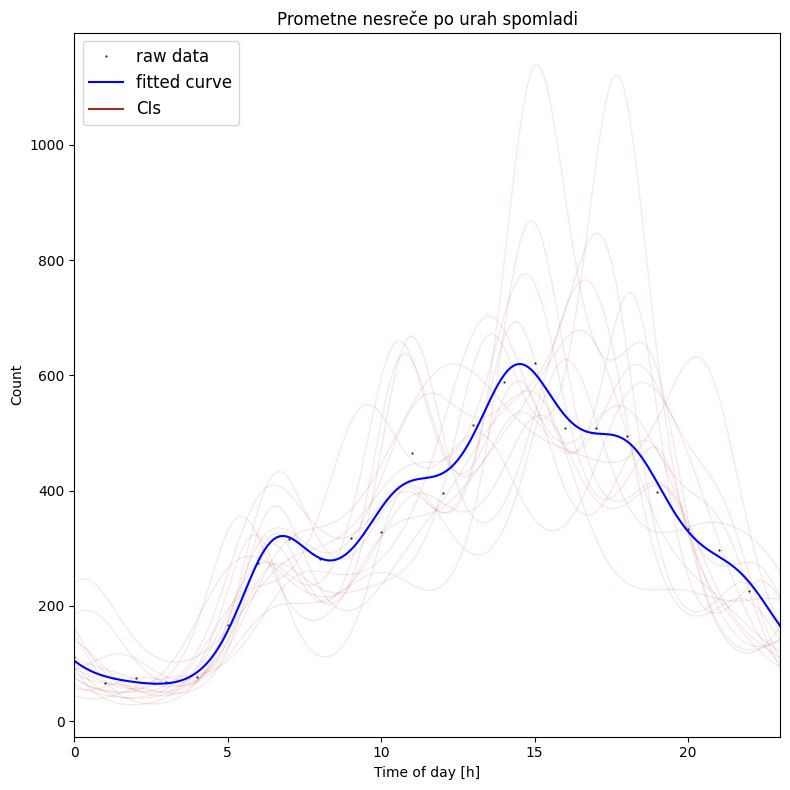

Intervali zaupanja:


,0,1
0,5.436589,5.654953
1,-0.699425,-0.373235
2,-0.906072,-0.550851
3,-0.454452,0.036688
4,-0.365015,-0.000406
5,-0.389864,0.035786
6,-0.183240,0.253890
7,-0.217531,0.173811
8,-0.071094,0.291507
9,-0.057676,0.161741


In [16]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah spomladi', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [17]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,277.3
mesor,342.13
peaks,[14.51]
heights,[619.43]
amplitude_CIs,"[200.33, 394.92]"
mesor_CIs,"[262.4, 458.86]"
peaks_CIs,"[13.76, 15.14]"
heights_CIs,"[463.0, 853.51]"
